<h2> Neural Style Transfer - Art Generation </h2>

- For a step-by-step walkthrough of the code, please see "neural_style_transfer_walkthrough.ipynb"
- This notebook imports helper functions from my custom module "nst_helper_functions.py"
- To generate an image, simply call the function below with the appropriate arguments.

In [1]:
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd gdrive/MyDrive/Colab Notebooks/colab_upload

In [3]:
# custom module with helper functions
from nst_helper_functions import load_resize, content_cost, style_cost, clip_0_1, tensor_to_image, train_step, plot_gen_image

In [4]:
def generate_image(content_image_path, style_image_path, learning_rate = 0.05, 
                    epochs = 100, alpha = 10, beta = 1000, output_file_name = 'generated_image.jpg', 
                    caption_1 = None, caption_2 = None):
    """
    Generates an image with the content of a "content image" in the style of a "style image"
    Saves iterations of the generated image
    Saves a plot showing the content image, style image, and generated image side by side

    Arguments:
    content_image_path -- path to content image file -- string
    style_image_path -- path to style image file -- string
    learning_rate -- float
    epochs -- int
    alpha -- weight for the content cost when calculating the total cost
    beta -- weight for the style cost when calculating the total cost
    output_file_name -- name of the output file showing the three-image plot
    caption_1 -- caption for image 1 (content image)
    caption_2 -- caption for image 2 (style image)
    
    """
    
    # load and re-size content and style images
    content_image = load_resize(content_image_path, 400)
    style_image = load_resize(style_image_path, 400)

    # pre-process images
    # Convert the values in content_image and style_image to float32 types, then save as tf.Variable
    # Note that tf.image.convert_image_dtype automatically normalises values to range 0-1

    preprocessed_content = tf.Variable (tf.image.convert_image_dtype(content_image, tf.float32))        # (1, img_size, img_size, 3)
    preprocessed_style = tf.Variable (tf.image.convert_image_dtype(style_image, tf.float32))            # (1, img_size, img_size, 3)


    # Load VGG19 model

    # include_top = False --> don't load the three fully connected layers at the top of the model
    # choose model trained on imagenet
    vgg_model = VGG19(include_top = False, weights='imagenet')

    # Freeze weights
    vgg_model.trainable = False

    # To compute the content cost function (J_content), we will use the final layer of block5 ('block5_conv4')
    # To compute the style cost function (J_style), we will use: ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

    # Define VGG19 layers with which to encode the content and style
    content_layer = 'block5_conv4'
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

    # content_model: model that returns the activations of VGG19's hidden layer 'block5_conv4'
    # style_models: list of models, each of which outputs the activations of a VGG19 hidden layer

    content_model = Model(inputs = vgg_model.input, outputs = vgg_model.get_layer(content_layer).output)
    style_models = [Model(inputs = vgg_model.input, outputs = vgg_model.get_layer(style_layer).output) for style_layer in style_layers]

    # Create optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    # initialise the generated image to be the same as the content image
    # use tf.identity to create deep copy
    # use tf.Variable since "generated" will be updated
    content = tf.identity(preprocessed_content)         
    style = tf.identity(preprocessed_style)
    generated = tf.Variable(tf.identity(preprocessed_content))

    # add noise to the generated_image. 
    # If the generated_image is only "slightly" similar to the content image, 
    # and has a lot of noise, it will more rapidly match the style image.
    noise = tf.random.uniform(tf.shape(generated), -0.25, 0.25)
    generated = tf.add(generated, noise)
    generated = tf.clip_by_value(generated, clip_value_min=0.0, clip_value_max=1.0)
    generated = tf.Variable(generated)

    epochs = epochs
    J_lowest = 1000000000
    for i in range (epochs + 1):
        J_total = train_step(content, style, generated, content_model, style_models, alpha = alpha, beta = beta, optimizer = optimizer)
        if i % 10 == 0:
            print (f'Epoch: {i}, J_total: {J_total}')
        if i % 10 == 0:
            if J_total < J_lowest:
                J_lowest = J_total
                image = tensor_to_image(generated)
                imshow(image)
                plt.figure(figsize = (4,4), dpi = 80)
                plt.show()
                image.save(f'./outputs/image_{i}.jpg')

    plot_gen_image(preprocessed_content[0], preprocessed_style[0], image, 
                    epochs, alpha, beta, learning_rate, 
                    output_file_name, caption_1, caption_2)

2022-09-27 10:07:41.464947: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch: 0, J_total: 629879.0625


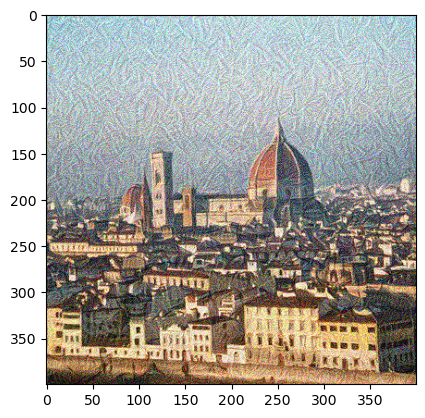

<Figure size 320x320 with 0 Axes>

Epoch: 10, J_total: 71293.9765625


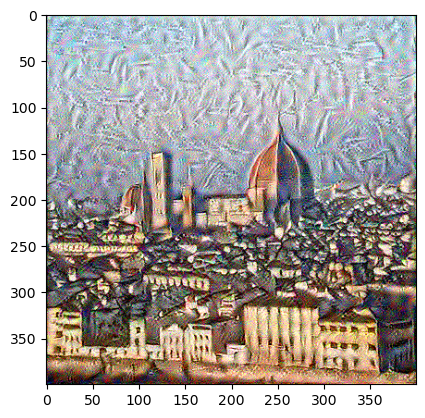

<Figure size 320x320 with 0 Axes>

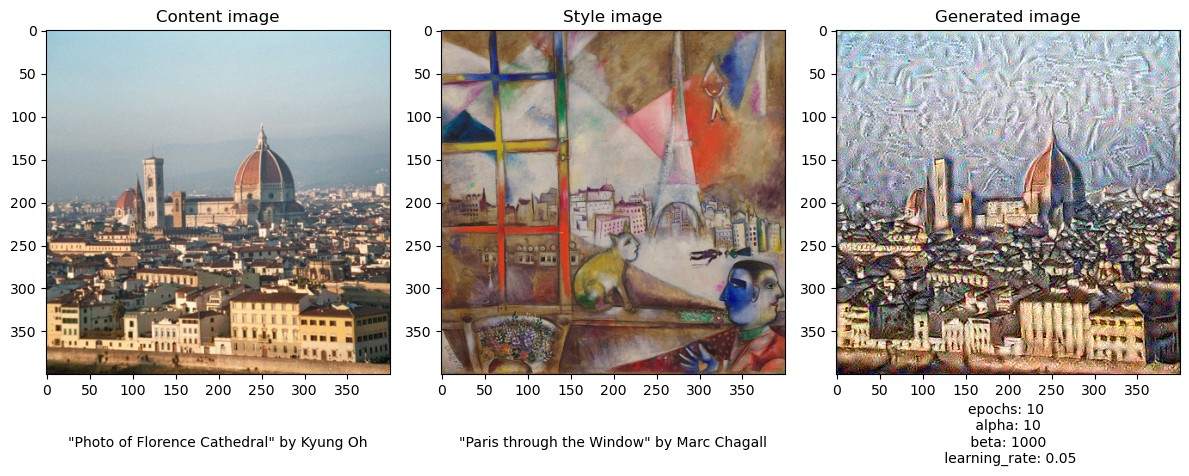

In [5]:
content_image_path = './images/florence_dome_2.jpg'
style_image_path = './images/chagall_paris_through_the_window.jpg'
learning_rate = 0.05
epochs = 10
alpha = 10
beta = 1000
output_file_name = 'florence_chagall.jpg'
caption_1 = '"Photo of Florence Cathedral" by Kyung Oh'
caption_2 = '"Paris through the Window" by Marc Chagall'

generate_image(content_image_path, style_image_path, learning_rate, epochs, alpha, beta, output_file_name, caption_1, caption_2)